In [2]:
# For working with the data
import pandas as pd
import numpy as np

# For encoding the Browser Name and Version column
import hashlib

# For scaling the data
from sklearn.preprocessing import StandardScaler

# For reducing the number of dimensions 
from sklearn.decomposition import PCA

# For creating the model for anomaly detection
from sklearn.cluster import KMeans 
from sklearn.mixture import GaussianMixture 

# For visualizing the data and results
import matplotlib.pyplot as plt
import seaborn as sns

# For exporting the model
import joblib

In [3]:
# Load your dataset
df = pd.read_csv('cleaned_dataframe.csv')

In [4]:
# Displaying few entries
df.head()

,User ID,IP Address,Country,Region,City,Device Type,Login Successful,Browser Name,Version,Year,Month,Day,Hour,Minute,Second
0,-3284137479262433373,81.167.144.58,NO,Vestland,Urangsvag,mobile,True,Android,2.3.3.2672,2020,2,3,12,43,55
1,-4618854071942621186,10.0.0.47,US,Virginia,Ashburn,mobile,False,Chrome Mobile WebView,85.0.4183,2020,2,3,12,43,59
2,7246533443898239661,80.202.228.214,NO,Unknown,Unknown,desktop,True,Chrome,69.0.3497.17.19,2020,2,3,12,44,7
3,-3243978724802435038,170.39.78.177,US,Unknown,Unknown,mobile,False,Chrome Mobile,81.0.4044.1931,2020,2,3,12,44,12
4,8076000552587369902,10.0.61.212,NO,Unknown,Unknown,mobile,False,MiuiBrowser,12.6.5,2020,2,3,12,44,17


In [5]:
# Remove entries where 'City' column equals 'Unknown'
df = df[df['City'] != 'Unknown']

In [6]:
# Displaying few entries
df.head()

,User ID,IP Address,Country,Region,City,Device Type,Login Successful,Browser Name,Version,Year,Month,Day,Hour,Minute,Second
0,-3284137479262433373,81.167.144.58,NO,Vestland,Urangsvag,mobile,True,Android,2.3.3.2672,2020,2,3,12,43,55
1,-4618854071942621186,10.0.0.47,US,Virginia,Ashburn,mobile,False,Chrome Mobile WebView,85.0.4183,2020,2,3,12,43,59
5,-3065936140549856249,92.221.109.162,NO,Rogaland,Sandnes,desktop,True,Chrome,69.0.3497.17.28,2020,2,3,12,44,19
7,-9080829243863829585,156.52.48.83,NO,Viken,Gressvik,desktop,True,Chrome,79.0.3945.192.203,2020,2,3,12,44,24
9,-8296667206273764769,82.147.58.93,NO,Oslo County,Oslo,mobile,True,Android,2.3.3.2672,2020,2,3,12,44,30


In [7]:
def custom_hash_function(browser_name, version):
    string_to_hash = browser_name + version
    hash_object = hashlib.md5(string_to_hash.encode())
    hash_integer = int(hash_object.hexdigest(), 16) & 0xffffffff
    return hash_integer

# Apply custom hash function to create 'Browser Info' column
df['Browser Info'] = df.apply(lambda row: custom_hash_function(row['Browser Name'], row['Version']), axis=1)

# Drop the 'Browser Name' and 'Version' columns
df = df.drop(['Browser Name', 'Version'], axis=1)

In [8]:
# Encoding the Login Successful column
df['Login Successful'] = df['Login Successful'].astype(int)

In [9]:
# Displaying few entries
df.head()

,User ID,IP Address,Country,Region,City,Device Type,Login Successful,Year,Month,Day,Hour,Minute,Second,Browser Info
0,-3284137479262433373,81.167.144.58,NO,Vestland,Urangsvag,mobile,1,2020,2,3,12,43,55,2151221952
1,-4618854071942621186,10.0.0.47,US,Virginia,Ashburn,mobile,0,2020,2,3,12,43,59,1976883002
5,-3065936140549856249,92.221.109.162,NO,Rogaland,Sandnes,desktop,1,2020,2,3,12,44,19,3519769814
7,-9080829243863829585,156.52.48.83,NO,Viken,Gressvik,desktop,1,2020,2,3,12,44,24,2842829293
9,-8296667206273764769,82.147.58.93,NO,Oslo County,Oslo,mobile,1,2020,2,3,12,44,30,2151221952


In [10]:
# Encoding the Device Type column
one_hot_encoded = pd.get_dummies(df['Device Type'], prefix='Device')
df = pd.concat([df, one_hot_encoded], axis=1)
df.drop(["Device Type"], inplace=True, axis=1)

In [11]:
# Displaying few entries
df.head()

,User ID,IP Address,Country,Region,City,Login Successful,Year,Month,Day,Hour,Minute,Second,Browser Info,Device_bot,Device_desktop,Device_mobile,Device_tablet,Device_unknown
0,-3284137479262433373,81.167.144.58,NO,Vestland,Urangsvag,1,2020,2,3,12,43,55,2151221952,0,0,1,0,0
1,-4618854071942621186,10.0.0.47,US,Virginia,Ashburn,0,2020,2,3,12,43,59,1976883002,0,0,1,0,0
5,-3065936140549856249,92.221.109.162,NO,Rogaland,Sandnes,1,2020,2,3,12,44,19,3519769814,0,1,0,0,0
7,-9080829243863829585,156.52.48.83,NO,Viken,Gressvik,1,2020,2,3,12,44,24,2842829293,0,1,0,0,0
9,-8296667206273764769,82.147.58.93,NO,Oslo County,Oslo,1,2020,2,3,12,44,30,2151221952,0,0,1,0,0


In [12]:
# Separating IP address column into four octets
df[['IP_Octet1', 'IP_Octet2', 'IP_Octet3', 'IP_Octet4']] = df['IP Address'].str.split('.', expand=True)
df.drop(["IP Address"], inplace=True, axis=1)

df['IP_Octet1'] = df['IP_Octet1'].astype(int)
df['IP_Octet2'] = df['IP_Octet2'].astype(int)
df['IP_Octet3'] = df['IP_Octet3'].astype(int)
df['IP_Octet4'] = df['IP_Octet4'].astype(int)

In [13]:
# Displaying few entries of the updated dataframe
df.head()

,User ID,Country,Region,City,Login Successful,Year,Month,Day,Hour,Minute,...,Browser Info,Device_bot,Device_desktop,Device_mobile,Device_tablet,Device_unknown,IP_Octet1,IP_Octet2,IP_Octet3,IP_Octet4
0,-3284137479262433373,NO,Vestland,Urangsvag,1,2020,2,3,12,43,...,2151221952,0,0,1,0,0,81,167,144,58
1,-4618854071942621186,US,Virginia,Ashburn,0,2020,2,3,12,43,...,1976883002,0,0,1,0,0,10,0,0,47
5,-3065936140549856249,NO,Rogaland,Sandnes,1,2020,2,3,12,44,...,3519769814,0,1,0,0,0,92,221,109,162
7,-9080829243863829585,NO,Viken,Gressvik,1,2020,2,3,12,44,...,2842829293,0,1,0,0,0,156,52,48,83
9,-8296667206273764769,NO,Oslo County,Oslo,1,2020,2,3,12,44,...,2151221952,0,0,1,0,0,82,147,58,93


In [14]:
country_buckets = 200
region_buckets = 4000
city_buckets = 10000

# Define a helper function for consistent hashing
def consistent_hash(value, buckets):
    sha256 = hashlib.sha256()
    sha256.update(value.encode('utf-8'))
    hash_value = int(sha256.hexdigest(), 16)
    return hash_value % buckets

# Apply consistent hashing to the columns
df['Country'] = df['Country'].apply(lambda x: consistent_hash(x, country_buckets))
df['Region'] = df['Region'].apply(lambda x: consistent_hash(x, region_buckets))
df['City'] = df['City'].apply(lambda x: consistent_hash(x, city_buckets))

In [15]:
# Displaying few entries of the updated dataframe
df.head()

,User ID,Country,Region,City,Login Successful,Year,Month,Day,Hour,Minute,...,Browser Info,Device_bot,Device_desktop,Device_mobile,Device_tablet,Device_unknown,IP_Octet1,IP_Octet2,IP_Octet3,IP_Octet4
0,-3284137479262433373,2,666,7320,1,2020,2,3,12,43,...,2151221952,0,0,1,0,0,81,167,144,58
1,-4618854071942621186,21,1167,6371,0,2020,2,3,12,43,...,1976883002,0,0,1,0,0,10,0,0,47
5,-3065936140549856249,2,427,8897,1,2020,2,3,12,44,...,3519769814,0,1,0,0,0,92,221,109,162
7,-9080829243863829585,2,3533,2474,1,2020,2,3,12,44,...,2842829293,0,1,0,0,0,156,52,48,83
9,-8296667206273764769,2,540,5803,1,2020,2,3,12,44,...,2151221952,0,0,1,0,0,82,147,58,93


In [16]:
# Perform frequency encoding on the "User ID" column
freq_encoding = df['User ID'].value_counts().to_dict()
df['User ID'] = df['User ID'].map(freq_encoding)

In [17]:
# Displaying few entries of the updated dataframe
df.head()

,User ID,Country,Region,City,Login Successful,Year,Month,Day,Hour,Minute,...,Browser Info,Device_bot,Device_desktop,Device_mobile,Device_tablet,Device_unknown,IP_Octet1,IP_Octet2,IP_Octet3,IP_Octet4
0,19,2,666,7320,1,2020,2,3,12,43,...,2151221952,0,0,1,0,0,81,167,144,58
1,3,21,1167,6371,0,2020,2,3,12,43,...,1976883002,0,0,1,0,0,10,0,0,47
5,5,2,427,8897,1,2020,2,3,12,44,...,3519769814,0,1,0,0,0,92,221,109,162
7,19,2,3533,2474,1,2020,2,3,12,44,...,2842829293,0,1,0,0,0,156,52,48,83
9,1088,2,540,5803,1,2020,2,3,12,44,...,2151221952,0,0,1,0,0,82,147,58,93


In [18]:
# Displaying the number of entries in the final dataset
print("Number of entries:", format(len(df), ","))

Number of entries: 10,074,607


In [19]:
# Scale the data using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

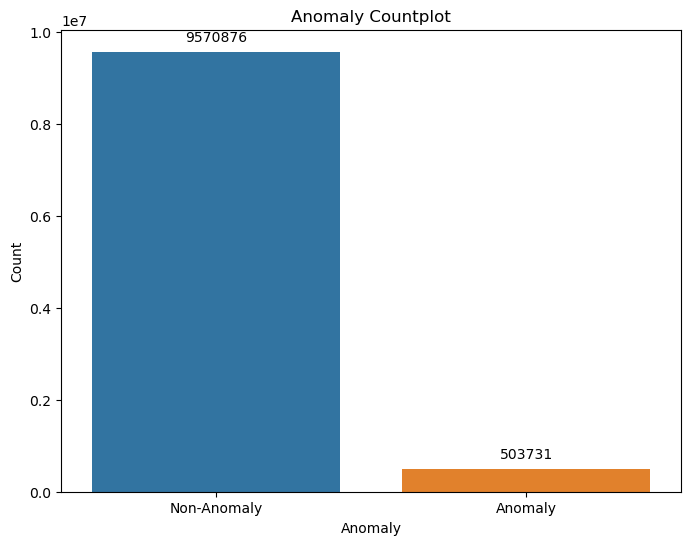

Threshold : 19.844993514473185


In [20]:
# Training the GMM model
gmm = GaussianMixture(n_components=50) # Chose 50 based on previous experiences and time & memory constraint
gmm.fit(scaled_data)

# Calculate log-likelihood scores
log_likelihoods = gmm.score_samples(scaled_data)

# Set threshold for anomalies
threshold = np.percentile(log_likelihoods, 5)

# Identify anomalies
anomalies = scaled_data[log_likelihoods < threshold]
non_anomalies = scaled_data[log_likelihoods >= threshold]

# Plot countplot of anomalies vs. non-anomalies
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=["Non-Anomaly"] * len(non_anomalies) + ["Anomaly"] * len(anomalies))
plt.xlabel("Anomaly")
plt.ylabel("Count")
plt.title("Anomaly Countplot")

# Display the count on the countplot bins
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()

# Export this
print("Threshold", ":", threshold)

In [21]:
# Get the indices of the anomalies
anomaly_indices = np.where(log_likelihoods < threshold)[0]

# Get the feature contributions for the anomalies
anomaly_contributions = np.abs(scaled_data[anomaly_indices] - gmm.means_[gmm.predict(scaled_data[anomaly_indices])])

# Sum the contributions across all anomalies
total_contributions = np.sum(anomaly_contributions, axis=0)

# Sort the features based on their contribution
sorted_indices = np.argsort(-total_contributions)
sorted_features = df.columns[sorted_indices]
sorted_contributions = total_contributions[sorted_indices]

# Print the features and their contributions in sorted order
print("Features and their Contributions (Sorted):")
for index, contribution in enumerate(sorted_contributions):
    feature = sorted_features[index]
    print("{}: {}".format(feature, contribution))

Features and their Contributions (Sorted):
Region: 474444.60290556616
IP_Octet4: 466267.2680339103
IP_Octet3: 464213.09928588406
Minute: 459224.7686577625
Second: 457384.1339736435
Day: 456623.3486174119
City: 454739.1255485107
Hour: 440286.5963064323
Browser Info: 439172.207555789
IP_Octet1: 398292.91827873833
IP_Octet2: 392055.97302166844
Login Successful: 379306.891101604
Month: 347684.58628912823
Country: 262737.147346538
Year: 34797.99470515987
Device_desktop: 32239.901243645814
Device_mobile: 31612.83192754294
User ID: 12375.138576222977
Device_tablet: 9.815661713985513e-08
Device_unknown: 4.331110906724556e-08
Device_bot: 1.6342284491800696e-10


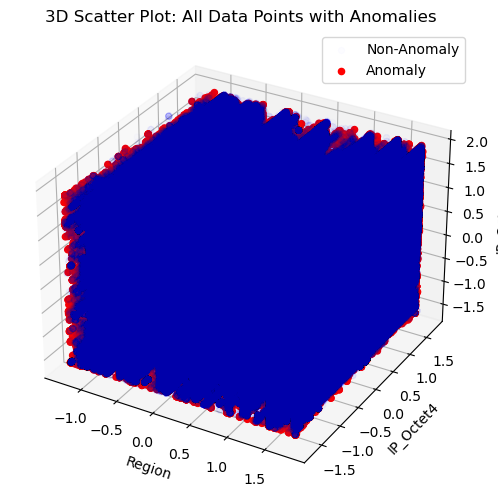

In [22]:
top_features = sorted_features[:3]
top_features_indices = sorted_indices[:3]

# Create a 3D scatter plot with all data points and use anomalies as hue
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for non-anomalies
ax.scatter(scaled_data[:, top_features_indices[0]], scaled_data[:, top_features_indices[1]], scaled_data[:, top_features_indices[2]], c='b', label='Non-Anomaly', alpha=0.01)

# Scatter plot for anomalies (darkened)
ax.scatter(scaled_data[anomaly_indices, top_features_indices[0]], scaled_data[anomaly_indices, top_features_indices[1]], scaled_data[anomaly_indices, top_features_indices[2]], c='r', label='Anomaly', alpha=1)

ax.set_xlabel(top_features[0])
ax.set_ylabel(top_features[1])
ax.set_zlabel(top_features[2])
ax.set_title('3D Scatter Plot: All Data Points with Anomalies')
ax.legend()
plt.show()

In [23]:
# Perform PCA on the scaled data
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

In [29]:
max_clusters = 30  # Set the maximum number of clusters to consider

## Started from 15 based on previous experiences with the same data
## For n_clusters below 15, the wcss_value was very large
for n_clusters in range(15, max_clusters + 1, 2):
    kmeans = KMeans(n_clusters=n_clusters, n_init="auto")
    kmeans.fit(pca_data)
    wcss_value = kmeans.inertia_

    print(n_clusters, ":", wcss_value)

15 : 864037.9083192765
17 : 784417.930794344
19 : 663674.5704975508
21 : 618322.5315567614
23 : 542819.1831744482
25 : 500645.73114026187
27 : 453403.42252613284
29 : 429877.0177570358


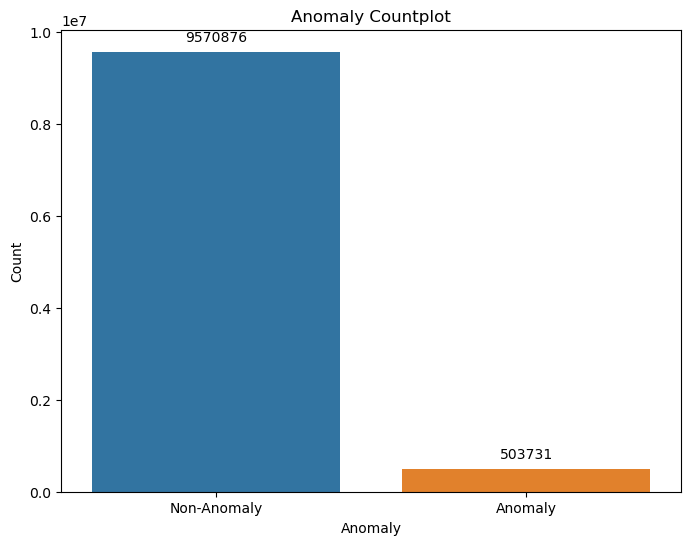

Threshold : 4.148080343148985


In [30]:
# Training the KMeans model
kmeans = KMeans(n_clusters=23, n_init="auto") # n_clusters were chosen based using elbow method
kmeans.fit(scaled_data)

# Calculate distances to nearest centroid for each data point
distances = kmeans.transform(scaled_data)
min_distances = np.min(distances, axis=1)

# Determine the threshold to classify anomalies
threshold = np.percentile(min_distances, 95)  # Adjust the percentile as needed

# Classify anomalies based on the threshold
anomalies = scaled_data[min_distances > threshold]
non_anomalies = scaled_data[min_distances <= threshold]

# Plot countplot of anomalies vs. non-anomalies
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=["Non-Anomaly"] * len(non_anomalies) + ["Anomaly"] * len(anomalies))
plt.xlabel("Anomaly")
plt.ylabel("Count")
plt.title("Anomaly Countplot")

# Display the count on the countplot bins
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()

# Export this
print("Threshold", ":", threshold)

In [31]:
# Get the indices of the anomalies
anomaly_indices = np.where(min_distances > threshold)[0]

# Get the feature contributions for the anomalies
anomaly_contributions = np.abs(scaled_data[anomaly_indices] - kmeans.cluster_centers_[kmeans.labels_[anomaly_indices]])

# Sum the contributions across all anomalies
total_contributions = np.sum(anomaly_contributions, axis=0)

# Sort the features based on their contribution
sorted_indices = np.argsort(-total_contributions)
sorted_features = df.columns[sorted_indices]
sorted_contributions = total_contributions[sorted_indices]

# Print the features and their contributions in sorted order
print("Features and their Contributions (Sorted):")
for index, contribution in enumerate(sorted_contributions):
    feature = sorted_features[index]
    print("{}: {}".format(feature, contribution))

Features and their Contributions (Sorted):
Hour: 579096.6507311556
Login Successful: 539886.7514531736
IP_Octet4: 529709.9396960784
Browser Info: 519308.90951098804
Second: 516315.1229645754
City: 511709.0240227463
Day: 509294.6995034476
IP_Octet3: 503371.0098692951
Minute: 501768.0807563887
Region: 418655.38245111477
IP_Octet1: 418314.05800283846
Month: 415584.8067848324
IP_Octet2: 401612.96946678305
Country: 352030.9193062448
Year: 264826.5275232936
Device_desktop: 172044.89716711018
Device_mobile: 169707.83720303845
Device_tablet: 5593.586683657868
User ID: 2317.9291915423382
Device_unknown: 3.703583136699384e-08
Device_bot: 1.0079112776600202e-09


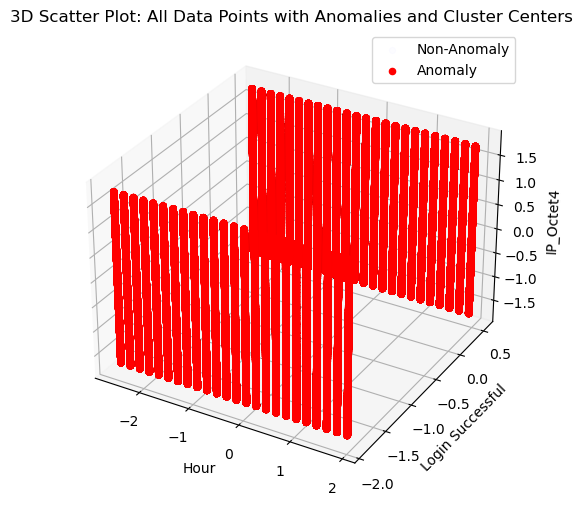

In [32]:
top_features = sorted_features[:3]
top_features_indices = sorted_indices[:3]

# Create a 3D scatter plot with all data points and use anomalies as hue
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for non-anomalies
ax.scatter(scaled_data[:, top_features_indices[0]], scaled_data[:, top_features_indices[1]], scaled_data[:, top_features_indices[2]], c='b', label='Non-Anomaly', alpha=0.01)

# Scatter plot for anomalies
ax.scatter(scaled_data[anomaly_indices, top_features_indices[0]], scaled_data[anomaly_indices, top_features_indices[1]], scaled_data[anomaly_indices, top_features_indices[2]], c='r', label='Anomaly', alpha=1)

ax.set_xlabel(top_features[0])
ax.set_ylabel(top_features[1])
ax.set_zlabel(top_features[2])
ax.set_title('3D Scatter Plot: All Data Points with Anomalies and Cluster Centers')
ax.legend()
plt.show()

In [33]:
# Export the models
joblib.dump(freq_encoding, 'freq_encoder_1_crore.joblib')
joblib.dump(scaler, "scaler_1_crore.pkl")
joblib.dump(kmeans, "kmeans_1_crore.pkl")
joblib.dump(gmm, "gmm_1_crore.pkl")

['gmm_1_crore.pkl']